In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import math
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

In [3]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [4]:
session = 'Mary-Anesthesia-20160912-02'
save_dir = '/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/band_power_correlations'
os.makedirs(save_dir, exist_ok=True)

# Run For All Sessions

In [11]:
# for session in tqdm([f[:-4] for f in os.listdir('/om/user/eisenaj/datasets/anesthesia/mat/propofolPuffTone') if f.endswith('.mat')]):
#     # NEURAL DATA
#     all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
#     data_class = get_data_class(session, all_data_dir)
#     variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'unitInfo']
#     session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
#     electrode_info, lfp, lfp_schema, session_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['unitInfo']
    
#     # VAR RESULTS
#     VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)
    
#     # COMPUTE SPECTROGRAMS
#     start_time = 0 # s
#     duration = int(lfp.shape[0]*dt) # s
#     unit_specs = np.zeros((lfp.shape[1], 164, int(duration/2)))

#     spectrogram_kwargs = dict(
#         method='multitaper',
#         spec_type='power',
#         time_width=2,
#         freq_width=0.5,
#         spacing=2,
#         freq_range=[0, 80],
#     )

#     start_step = int(start_time/dt)
#     length = int(duration/dt)

#     for i in tqdm(range(lfp.shape[1])):
#         signal_in = lfp[start_step:start_step + length, i]
#         spec, freq, timepts = spectra.spectrogram(signal_in, 1/dt, **spectrogram_kwargs)
#         unit_specs[i] = spec

#     unit_spec_power = 10*np.log10(unit_specs)

#     bands = {
#         'delta': [0.5, 4],
#         'theta': [4, 8],
#         'alpha': [8, 12],
#         'beta': [12, 35],
#         'gamma': [35, freq[-1]]
#     }
    
#     # EXPAND BAND POWER AND MEAN CRITICALITY
#     time_width = spectrogram_kwargs['time_width']
#     num_pts = np.min([int((timepts[-1] + time_width/2)/dt), np.min([int(VAR_results[area].end_time.iloc[-1]/dt) for area in VAR_results.keys()])])

#     band_power_dict = {}
#     criticality_dict = {}
#     iterator = tqdm(total=len(VAR_results)*len(bands) + len(VAR_results))
#     for area in VAR_results.keys():
#         band_power_dict[area] = {}
#         for band in bands.keys():
#             freq_inds = np.logical_and(freq >= bands[band][0], freq <= bands[band][1])

#             # BROADCAST TO FULL SIZE
#             if area == 'all':
#                 area_specs = unit_spec_power[:, freq_inds, :]
#             else:
#                 area_specs = unit_spec_power[np.where(electrode_info['area'] == area)[0], : , :][:, freq_inds, :]
#             band_power = area_specs.mean(axis=0).mean(axis=0)
#             band_power_expanded = np.zeros(num_pts)
#             for t, bp in zip(timepts, band_power):
#                 start_ind = int((t - time_width/2)/dt)
#                 end_ind = int((t + time_width/2)/dt)
#                 band_power_expanded[start_ind:end_ind] = bp

#             band_power_dict[area][band] = band_power_expanded

#             iterator.update()

#         criticality_expanded = np.zeros(num_pts)
#         for i, row in VAR_results[area].iterrows():
#             start_ind = int(row.start_time/dt)
#             end_ind = int(row.end_time/dt)
#             ci = row.criticality_inds.mean()

#             criticality_expanded[start_ind:end_ind] = ci

#         zero_run_inds = zero_runs(criticality_expanded)
#         if len(zero_run_inds) > 0:
#             for zero_run_ind in zero_run_inds:
#                 criticality_expanded[zero_run_ind[0]:zero_run_ind[1]] = np.linspace(criticality_expanded[zero_run_ind[0] - 1], criticality_expanded[zero_run_ind[1] + 1], zero_run_ind[1] - zero_run_ind[0])

#         criticality_dict[area] = criticality_expanded

#         iterator.update()
#     iterator.close()
    
#     # CORRELATIONS
#     correlations = {}
#     p_values = {}
#     iterator = tqdm(total=len(VAR_results)*len(bands))
#     for area in VAR_results.keys():
#         correlations[area] = {}
#         p_values[area] = {}
#         for band in bands.keys():
#             correlations[area][band], p_values[area][band] = scipy.stats.pearsonr(band_power_dict[area][band], criticality_dict[area])
#             iterator.update()
#     iterator.close()

#     areas = list(VAR_results.keys())
#     band_names = list(bands.keys())

#     correlation_mat = np.zeros((len(areas), len(band_names)))

#     for i, area in enumerate(areas):
#         for j, band_name in enumerate(band_names):
#             correlation_mat[i][j] = correlations[area][band_name]
            
#     results = dict(
#     criticality_dict=criticality_dict,
#     band_power_dict=band_power_dict,
#     areas=areas,
#     band_names=band_names,
#     correlation_mat=correlation_mat,
#     correlations=correlations
#     )
    
#     save(results, os.path.join(save_dir, session))

# Compile

In [69]:
sections = ['whole', 'wake', 'anesthesia']
areas = ['7b', 'CPB', 'FEF', 'vlPFC', 'all']
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

In [66]:
correlations = {}
for section in sections:
    correlations[section] = {}
    for area in areas:
        correlations[section][area] = {}
        for band in bands:
            correlations[section][area][band] = []

In [67]:
sessions = [f[:-4] for f in os.listdir('/om/user/eisenaj/datasets/anesthesia/mat/propofolPuffTone') if f.endswith('.mat')]

In [68]:
for session in tqdm(sessions):
    band_power_correls = load(os.path.join(save_dir, session))

    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    session_info = session_vars['sessionInfo']

    # iterator = tqdm(total = len(band_power_correls['areas'])*len(band_power_correls['band_names']))
    for area in band_power_correls['areas']:
        for band in band_power_correls['band_names']:
            # WHOLE SESSION
            correlations['whole'][area][band].append(band_power_correls['correlations'][area][band])

            # WAKE + ANESTHESIA
            time = np.arange(band_power_correls['criticality_dict'][area].shape[0])*dt
            eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

            wakeful_inds = time < session_info['drugStart'][0]
            correlations['wake'][area][band].append(scipy.stats.pearsonr(band_power_correls['criticality_dict'][area][wakeful_inds], band_power_correls['band_power_dict'][area][band][wakeful_inds])[0])

            anesthetic_inds = np.logical_and(time > eyes_close, time < session_info['drugEnd'][1])
            correlations['anesthesia'][area][band].append(scipy.stats.pearsonr(band_power_correls['criticality_dict'][area][anesthetic_inds], band_power_correls['band_power_dict'][area][band][anesthetic_inds])[0])

    #         iterator.update()
    # iterator.close()

  0%|          | 0/21 [00:00<?, ?it/s]

In [74]:
correlation_mats = {}
for section in sections:
    correlation_mats[section] = {}
    correlation_mats[section]['mean'] = np.zeros((len(areas), len(bands)))
    correlation_mats[section]['std_error'] = np.zeros((len(areas), len(bands)))
    for i, area in enumerate(areas):
        for j, band in enumerate(bands):
            correlation_mats[section]['mean'][i][j] = np.mean(correlations[section][area][band])
            correlation_mats[section]['std_error'][i][j] = np.std(correlations[section][area][band])/np.sqrt(len(correlations[section][area][band]))

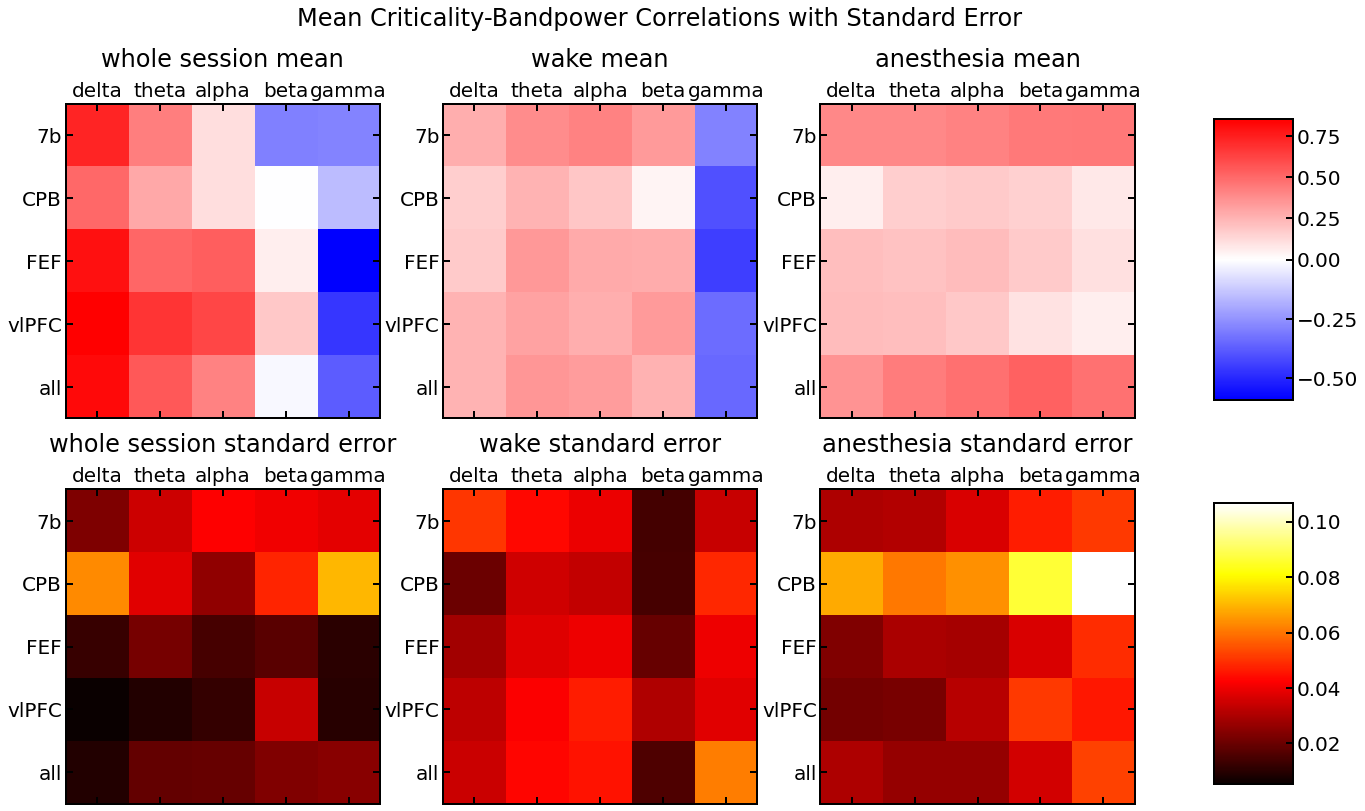

In [124]:
plt.style.use('../../sci_style.py')
fig, axs = plt.subplots(2, 3, figsize=(22, 13))

for i, info in enumerate(['mean', 'std_error']):
    
    vmin = np.Inf
    vmax = -np.Inf
    for section in sections:
        if correlation_mats[section][info].min() < vmin:
            vmin = correlation_mats[section][info].min()
        
        if correlation_mats[section][info].max() > vmax:
            vmax = correlation_mats[section][info].max()
    
    if info == 'mean':
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        cmap = 'bwr'
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = 'hot'
    
    for j, section in enumerate(sections):
        ax = axs[int((i*3 + j)/3)][(i*3 + j)%3]
        ax.set_yticks(np.arange(5))
        ax.set_yticklabels(areas)
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels(band_names)
        if info == 'mean':
            ax.set_title(f"{'whole session' if section == 'whole' else section} {info}")
        else:
            ax.set_title(f"{'whole session' if section == 'whole' else section} standard error")
        mat = ax.matshow(correlation_mats[section][info], cmap = cmap, norm=norm)
    
    fig.subplots_adjust(right=0.8)
    if info == 'mean':
        cbar_ax = fig.add_axes([0.85, 0.560, 0.05, 0.3])
    else:
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.3])
    fig.colorbar(mat, cax=cbar_ax)
# plt.tight_layout(
plt.suptitle("Mean Criticality-Bandpower Correlations with Standard Error")
plt.show()

# Session Plots

In [148]:
all_criticality = {}
all_bandpower = {}
for area in areas:
    all_criticality[area] = np.zeros((int(90*60/dt), len(sessions)))
    all_bandpower[area] = {}
    for band in bands:
        all_bandpower[area][band] = np.zeros((int(90*60/dt), len(sessions)))

In [151]:
for i, session in enumerate(tqdm(sessions)):
    band_power_correls = load(os.path.join(save_dir, session))

    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    session_info = session_vars['sessionInfo']
    
    for area in areas:
        
        time = np.arange(band_power_correls['criticality_dict'][area].shape[0])*dt
        inds = np.logical_and(time > (session_info['drugStart'][0] - 15*60), time < (session_info['drugEnd'][1] + 15*60))

        all_criticality[area][:np.min([int(90*60/dt), np.sum(inds)]), i] = band_power_correls['criticality_dict'][area][inds][:np.min([int(90*60/dt), np.sum(inds)])]
        
        for band in bands:
            
            all_bandpower[area][band][:np.min([int(90*60/dt), np.sum(inds)]), i] = band_power_correls['band_power_dict'][area][band][inds][:np.min([int(90*60/dt), np.sum(inds)])]
        

  0%|          | 0/21 [00:00<?, ?it/s]

In [153]:
area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

In [173]:
eyes_close_times = np.zeros(len(sessions))
eyes_open_times = np.zeros(len(sessions))
for i, session in tqdm(enumerate(sessions), total=len(sessions)):
    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    session_info = session_vars['sessionInfo']
    eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
    eyes_open = session_info['eyesOpen'][1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close_times[i] = (eyes_close - session_info['drugStart'][0])/60
    eyes_open_times[i] = (eyes_open - session_info['drugStart'][0])/60

  0%|          | 0/21 [00:00<?, ?it/s]

In [174]:
eyes_close_std_error = eyes_close_times.std()/np.sqrt(len(eyes_close_times))
eyes_open_std_error = eyes_open_times.std()/np.sqrt(len(eyes_open_times))

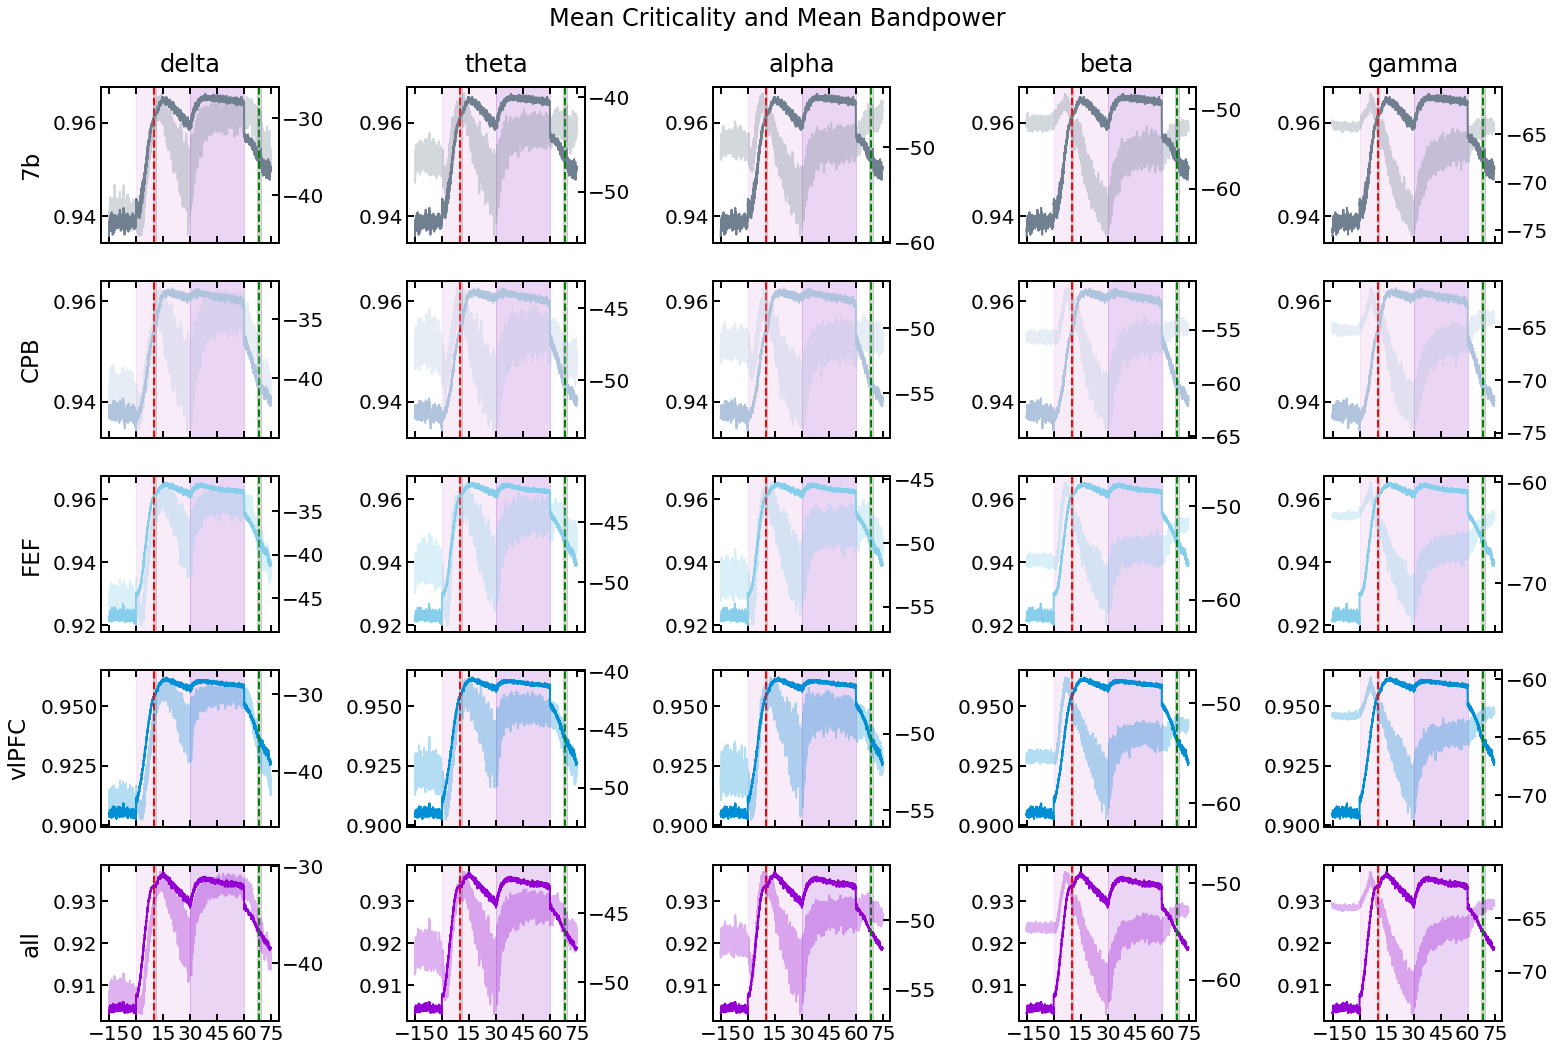

In [176]:
fig, axs = plt.subplots(5, 5, figsize=(22, 15), sharex=True)
end_ind = int(90*60/dt) - int(20/dt)

time = np.linspace(-15, 75, int(90*60/dt))

for i, area in enumerate(areas):
    for j, band in enumerate(bands):
        ax = axs[int((i*5 + j)/5)][(5*i + j) % 5]
        
        ax.plot(time[:end_ind], all_criticality[area].mean(axis=1)[:end_ind], c=area_colors[area])
        ax2 = ax.twinx()
        ax2.plot(time[:end_ind], all_bandpower[area][band].mean(axis=1)[:end_ind], c=area_colors[area], alpha=0.3)
        ax.set_xticks(np.arange(-15, 76, 15))
#         ax.set_xticklabels(np.arange(-15, 61, 15))
        
        min_val, max_val = ax.get_ylim()
        ax.axvline(eyes_close_times.mean(), linestyle='--', c='red', label="mean LOC")
        ax.axvspan(eyes_close_times.mean() - eyes_close_std_error, eyes_close_times.mean() + eyes_close_std_error, color='gray', alpha=0.3)
        ax.axvline(eyes_open_times.mean(), linestyle='--', c='green', label="mean ROC")
        ax.axvspan(eyes_open_times.mean() - eyes_open_std_error, eyes_open_times.mean() + eyes_open_std_error, color='gray', alpha=0.3)
        ax.axvspan(0, 30, color='plum', alpha=0.2, label=f"loading dose")
        ax.axvspan(30, 60, color='darkorchid', alpha=0.2, label=f"maintenance dose")

for i, ax in enumerate(axs[:, 0]):
    ax.set_ylabel(areas[i], fontsize=23)

for i, ax in enumerate(axs[0]):
    ax.set_title(bands[i])
    
plt.suptitle("Mean Criticality and Mean Bandpower")
plt.tight_layout()
plt.show()